#Prerequirements and imports

##Collab imports

In [ ]:
#collab only imports
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Imports

In [ ]:
import os
import cv2
import torch
import joblib 
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats

from pathlib import Path
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm.notebook import tqdm 
import statsmodels.api as sm

##Data copy

In [ ]:
%%time
GDRIVE_PROJECT_DIR = Path('/content/drive/My\ Drive/projects/idao/')

zip_data_path = (GDRIVE_PROJECT_DIR / 'data' / 'idao_dataset.zip').resolve()
!cp {zip_data_path} .
!unzip {'idao_dataset.zip'}

In [ ]:
%%time
GDRIVE_PRIVATE_TEST_ZIP = Path('/content/drive/My\ Drive/projects/idao/data/track_1_private_test_final_27_03.zip')
!rm -r /content/idao_dataset/private_test
!unzip {GDRIVE_PRIVATE_TEST_ZIP} -d ./idao_dataset

#Main

###Read data

In [ ]:
data_dir = Path('/content/idao_dataset/')

train_dir = Path(data_dir, 'train')
public_dir = Path(data_dir, 'public_test')
private_dir = Path(data_dir, 'private_test')

ER_train_dir = Path(train_dir, 'ER')
NR_train_dir = Path(train_dir, 'NR')

In [ ]:
ER_names = os.listdir(ER_train_dir)
NR_names = os.listdir(NR_train_dir)

ER_splitted_names = [n.split('_') for n in ER_names]
NR_splitted_names = [n.split('_') for n in NR_names]

ER_energy_idx = 6
NR_energy_idx = 7

In [ ]:
print(('_').join(ER_splitted_names[0]))
print(('_').join(NR_splitted_names[0]))
ER_test_energy = int(ER_splitted_names[0][ER_energy_idx])
NR_test_energy = int(NR_splitted_names[0][NR_energy_idx])
print(ER_test_energy)
print(NR_test_energy)

1.5527058839797974__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev312;1.png
-0.9998999834060669__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run1_ev173;1.png
3
20


In [ ]:
ER_energys = np.array([int(n[ER_energy_idx]) for n in ER_splitted_names])
NR_energys = np.array([int(n[NR_energy_idx]) for n in NR_splitted_names])

In [ ]:
print('NR: ', np.unique(NR_energys, return_counts=True))
print('ER: ', np.unique(ER_energys, return_counts=True))

NR:  (array([ 1,  3,  6, 10, 20, 30]), array([2177,    2, 2255,    2, 2208,    2]))
ER:  (array([ 1,  3,  6, 10, 20, 30]), array([   3, 2243,    1, 2272,    2, 2237]))


###Total sum destribution by specifix energy level

1
6
20


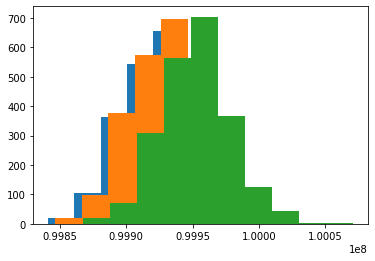

In [ ]:
for v in np.unique(NR_energys):
    v_sum = NR_sum[NR_energys == v]
    if len(v_sum) > 10:
        print(v)
        plt.hist(v_sum)
plt.show()

3
mean 99928.11952429781
median 99929.508
std 26.1639099724176
--------
10
mean 99940.61741065142
median 99941.115
std 25.87928060477219
--------
30
mean 99980.10057130085
median 99980.592
std 26.556066562151287
--------


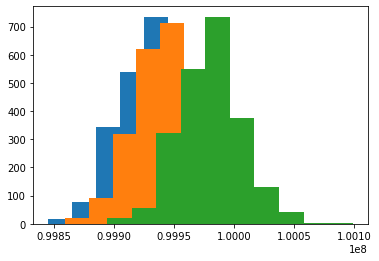

In [ ]:
for v in np.unique(ER_energys):
    v_sum = ER_sum[ER_energys == v]
    if len(v_sum) > 10:
        print(v)
        print('mean', v_sum.mean()/1000)
        print('median', np.median(v_sum)/1000)
        print('std', np.std(v_sum)/1000)

        plt.hist(v_sum)
        print('--------')
plt.show()

###Brightest spot localization tests

(281, 285)
10


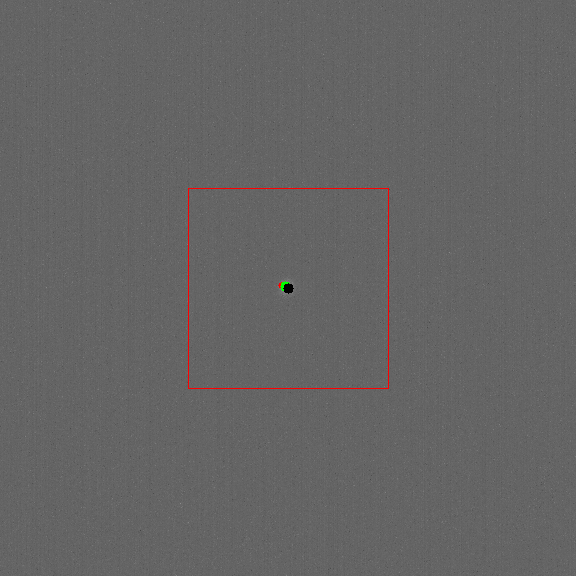

-----------
(271, 271)
30


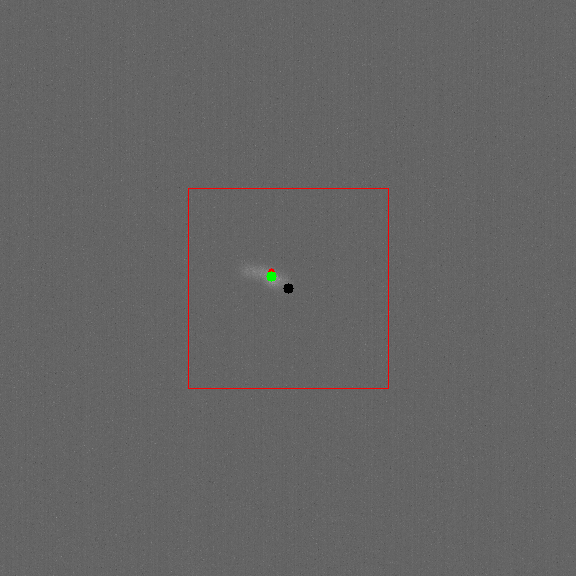

-----------
(285, 236)
30


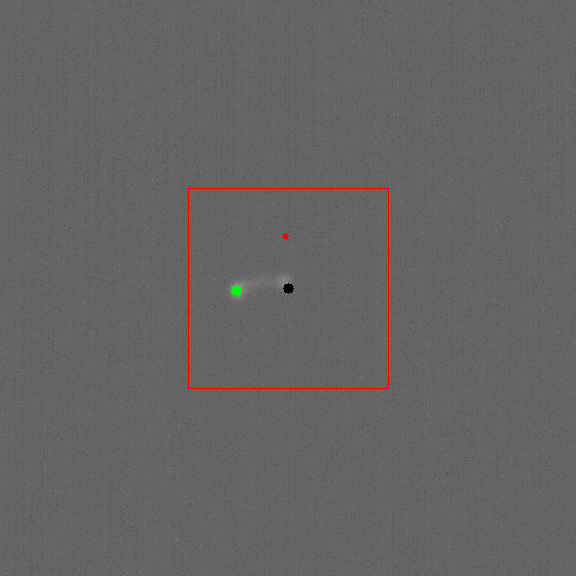

-----------
(280, 285)
3


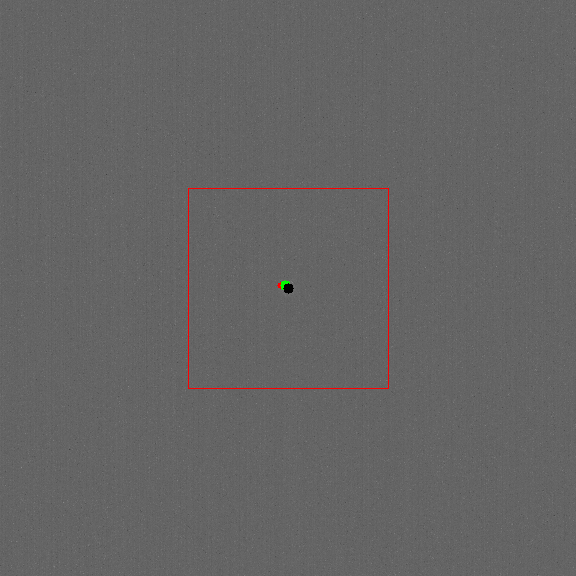

-----------
(283, 288)
3


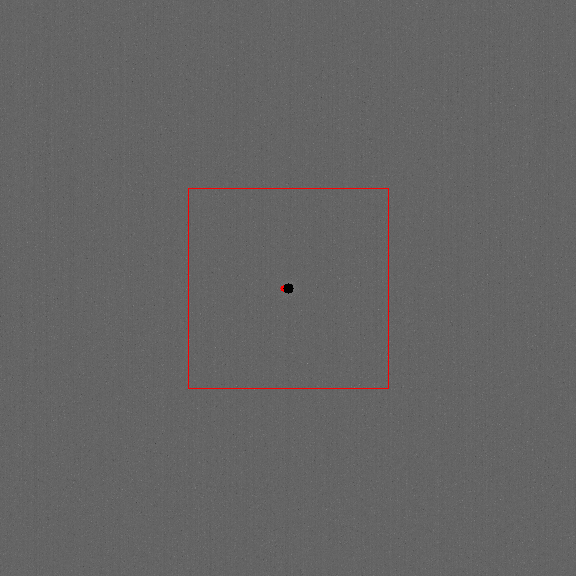

-----------
(281, 280)
10


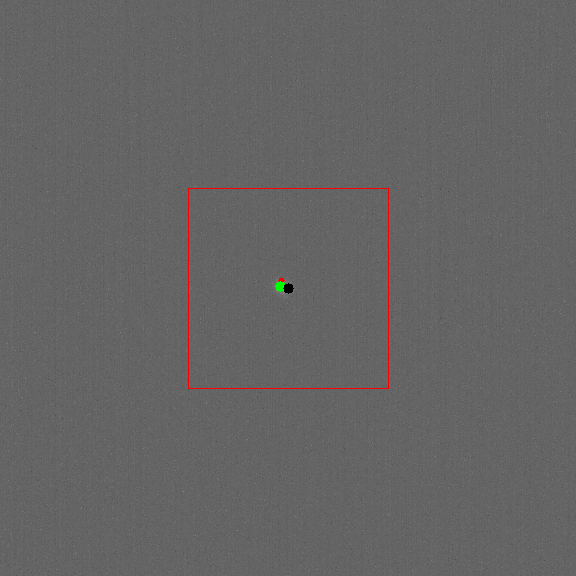

-----------
(280, 287)
3


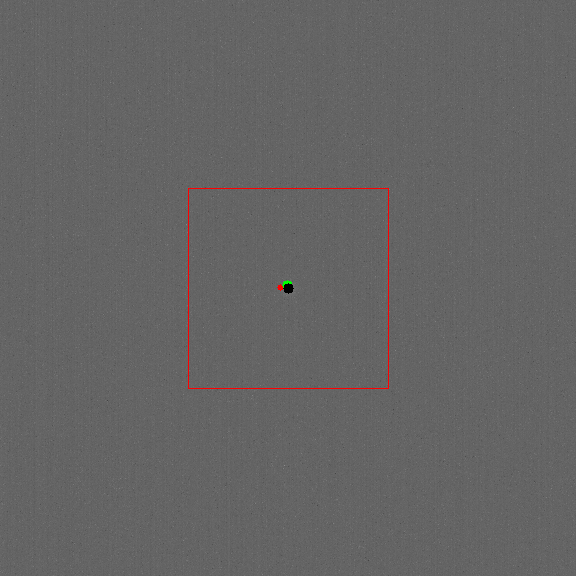

-----------
(279, 288)
10


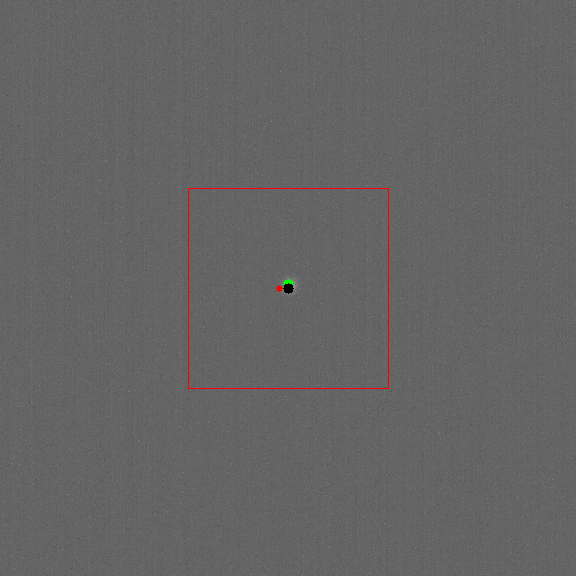

-----------
(320, 273)
30


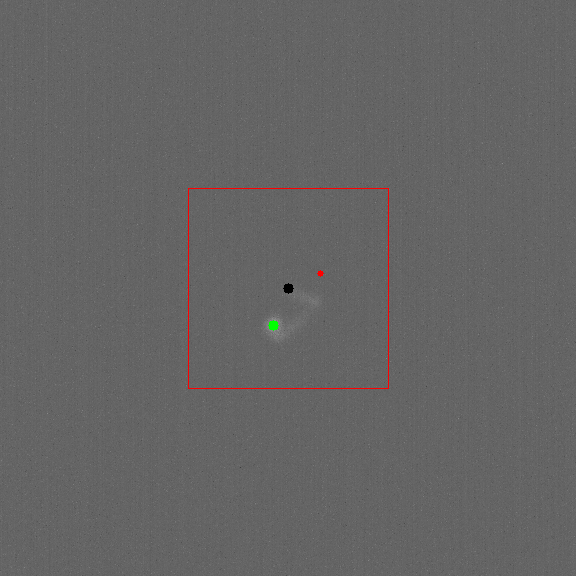

-----------
(276, 329)
30


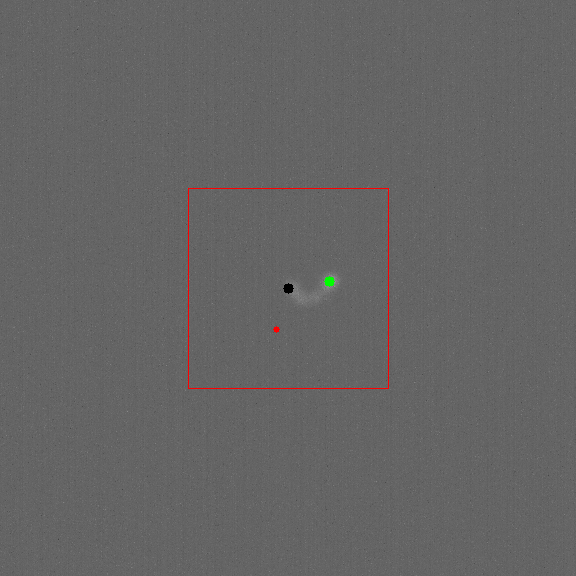

-----------
(281, 287)
3


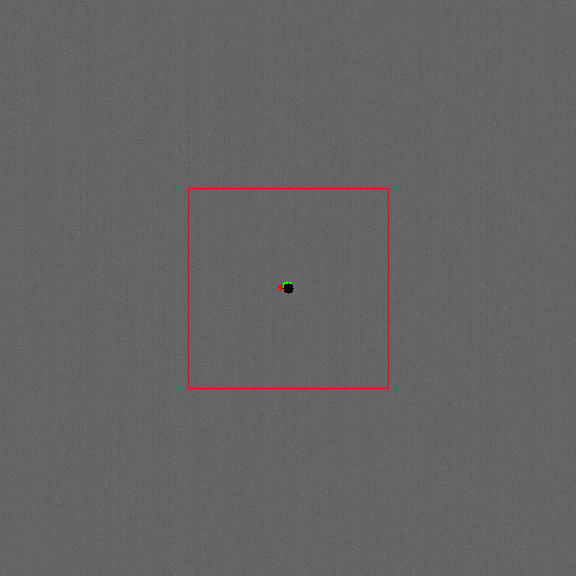

-----------
(348, 340)
30


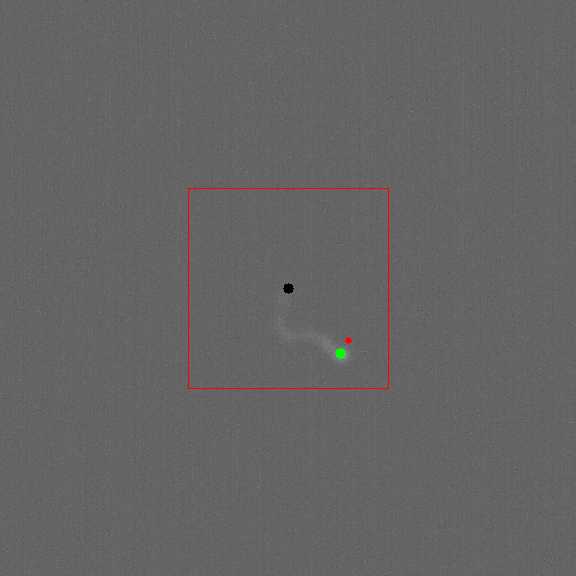

-----------


In [ ]:
for i, n in enumerate(ER_names):
    img_path = ER_train_dir / n
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    
    cv2_imshow(img)
    cv2_imshow()


    if i > 10:
        break


##Extract data

In [ ]:
def name_to_class(name):
    names = name.split("_")
    idx = [i for i, v in enumerate(names) if v == "keV"][0]
    return (names[idx - 2])

def name_to_energy(name):
    names = name.split("_")
    idx = [i for i, v in enumerate(names) if v == "keV"][0]
    return float(names[idx - 1])

blur_kernel = (25, 25)
blur_noise_area = [0, 100, 0, 100] #y_min: y_max, x_min: x_max
blur_std_coef = 9
sum_threshold = 10

###Extract_train_data

In [ ]:
def extract_train_data(img_paths, particle_class, dsr_ER_energy_level=None, dsr_NR_energy_level=None):
    '''
    Too bad to be commented
    '''
    if isinstance(dsr_ER_energy_level, int):
        dsr_ER_energy_level = tuple(dsr_ER_energy_level)

    if isinstance(dsr_NR_energy_level, int):
        dsr_NR_energy_level = tuple(dsr_NR_energy_level)

    energys = []

    areas = []
    sums = []
    stds = []
    moments_4 = []
    bs_distances = []
    maxVals = []

    if particle_class == 'ER':
        class_energy = ER_energys
        imgs_dir = ER_train_dir
    elif particle_class == 'NR':
        class_energy = NR_energys
        imgs_dir = NR_train_dir
    else:
        raise NotImplementedError

    for i, img_path in tqdm(enumerate(img_paths)):
        energy_level = name_to_energy(img_path.name)
        if particle_class == 'ER':
            if (dsr_ER_energy_level is not None) and (not (energy_level in dsr_ER_energy_level)):
                continue
        elif particle_class == 'NR': 
            if (dsr_NR_energy_level is not None) and (not (energy_level in dsr_NR_energy_level)):
                continue

        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        blur = cv2.GaussianBlur(img, blur_kernel, 0)

        blur_noise = blur[blur_noise_area[0]:blur_noise_area[1], blur_noise_area[2]:blur_noise_area[3]]
        blur_noise_mean = blur_noise.mean()
        blur_noise_std = blur_noise.std()
        
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(blur)
        img_center = np.flip(np.array(img.shape)//2)

        threshold_value = blur_noise_mean + blur_std_coef * blur_noise_std
        ret, mask = cv2.threshold(blur, threshold_value, 255, cv2.THRESH_BINARY)
        masked_blur = blur[mask==255]

        area = (mask.sum())/255
        sum = np.sum(masked_blur)
        std = np.std(masked_blur)    
        moment_4 = stats.moment(masked_blur, 4)

        if sum <= sum_threshold:
            bs_distance = 0
            maxVal = blur_noise_mean
        else:
            bs_distance = np.linalg.norm(np.array(maxLoc) - img_center)
        bs_distances.append(bs_distance)
 
        maxVals.append(maxVal)
        energys.append(energy_level)
        sums.append(sum)
        areas.append(area)
        stds.append(std)
        moments_4.append(moment_4)

    areas = np.array(areas)
    sums = np.array(sums)
    stds = np.array(stds)
    moments_4 = np.array(moments_4)
    bs_distances = np.array(bs_distances)
    maxVals = np.array(maxVals)    

    features = np.array([areas   , sums   , stds   , moments_4   , bs_distances   , maxVals])
    
    energys = np.array(energys, dtype=np.float64)
    
    features[np.isnan(features)] = 0
    return features, energys

###Extract_test_data

In [ ]:
def extract_test_data(img_paths):
    areas = []
    sums = []
    stds = []
    moments_4 = []
    bs_distances = []
    maxVals = []

    for i, img_path in tqdm(enumerate(img_paths)):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        blur = cv2.GaussianBlur(img, blur_kernel, 0)

        blur_noise = blur[blur_noise_area[0]:blur_noise_area[1], blur_noise_area[2]:blur_noise_area[3]]
        blur_noise_mean = blur_noise.mean()
        blur_noise_std = blur_noise.std()
        
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(blur)
        img_center = np.flip(np.array(img.shape)//2)

        threshold_value = blur_noise_mean + blur_std_coef * blur_noise_std
        ret, mask = cv2.threshold(blur, threshold_value, 255, cv2.THRESH_BINARY)
        masked_blur = blur[mask==255]

        area = (mask.sum())/255
        sum = np.sum(masked_blur)
        std = np.std(masked_blur)    
        moment_4 = stats.moment(masked_blur, 4)

        if sum <= sum_threshold:
            pass
            bs_distance = 0
            maxVal = blur_noise_mean
        else:
            bs_distance = np.linalg.norm(np.array(maxLoc) - img_center)
   
   
        bs_distances.append(bs_distance)
        maxVals.append(maxVal)
        sums.append(sum)
        areas.append(area)
        stds.append(std)
        moments_4.append(moment_4)

    areas = np.array(areas)
    sums = np.array(sums)
    stds = np.array(stds)
    moments_4 = np.array(moments_4)
    bs_distances = np.array(bs_distances)
    maxVals = np.array(maxVals)
            
    features = np.array([areas   , sums   , stds   , moments_4   , bs_distances   , maxVals])


    features[np.isnan(features)] = 0
    return features

###Model

In [ ]:
def find_nearest_class(x: np.array, classes: np.array=np.array([1, 3, 6, 10, 20, 30], dtype=np.float64)):
    classes = classes[:, np.newaxis]
    idx = np.argmin(abs(classes - x), axis=0)
    return classes[idx]


class RFRIDGE_Model():
    def __init__(self, ridge_kvargs={'alpha': 0.00001} , rf_kvargs= {}, feature_transform=None, one_model=None, random_state=13):
        self.rf_model = RandomForestRegressor(**rf_kvargs)
        self.ridge_model = Ridge(**ridge_kvargs)
        self.feature_transform = feature_transform
        
        if one_model is not None:
            if one_model == 'rf':
                self.ridge_model = None
            elif one_model == 'ridge':
                self.rf_model = None      
            else:
                raise ValueError


    def fit(self, X, y):
        if self.feature_transform is not None:
            X = self.feature_transform.fit_transform(X)
        for model in [self.rf_model, self.ridge_model]:
            if model is not None:
               model.fit(X, y)


    def predict(self, features, * , energy_to_class_mapping):
        if self.feature_transform is not None:
            features = self.feature_transform.transform(features)

        if self.rf_model is not None:
            rf_preds = self.rf_model.predict(features)
            rf_energy_preds = find_nearest_class(rf_preds)
        else:
            rf_preds = None
            rf_energy_preds = None

        if self.ridge_model is not None:
            ridge_preds = self.ridge_model.predict(features)
            ridge_energy_preds = find_nearest_class(ridge_preds)
        else:
            ridge_preds = None
            ridge_energy_preds = None

        print(np.unique(ridge_energy_preds, return_counts=True))
        print(np.unique(rf_energy_preds, return_counts=True))
        energy_preds = self.very_custom_stack(rf_preds=rf_energy_preds,
                                              ridge_preds=ridge_energy_preds)
        
        class_preds = np.zeros(shape=energy_preds.shape, dtype = np.int8)
        for key, value in energy_to_class_mapping.items():
            class_preds[energy_preds == key] = value

        return energy_preds, class_preds    

        
    def very_custom_stack(self, rf_preds, ridge_preds):
        assert (rf_preds is not None) or (ridge_preds is not None)
        if rf_preds is None:
            return ridge_preds
        elif ridge_preds is None:
            return rf_preds
        else:
            pred = np.zeros_like(rf_preds)

            #rewrite through np.where
            for i in range(len(rf_preds)):
                if ridge_preds[i] == 6 and rf_preds[i]==10:
                        pred[i] = 10
                elif rf_preds[i] <=6:
                    pred[i] = rf_preds[i]
                else:
                    pred[i] = ridge_preds[i]

        return pred

##Train

In [ ]:
##Train feature extraction

##ER
ER_paths = sorted(list(ER_train_dir.iterdir()))
ER_features, ER_energys = extract_train_data(ER_paths, 'ER', dsr_ER_energy_level, dsr_NR_energy_level)

##NR
NR_paths = sorted(list(NR_train_dir.iterdir()))
NR_features, NR_energys = extract_train_data(NR_paths, 'NR', dsr_ER_energy_level, dsr_NR_energy_level)

##Concat to all
energys = np.concatenate((ER_energys, NR_energys))
features = np.concatenate((ER_features, NR_features), axis=1).T

print(energys.shape)
print(features.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



(13404,)
(13404, 6)


In [ ]:
model = RFRIDGE_Model(feature_transform = MinMaxScaler(), one_model='ridge')
model.fit(features, energys)
joblib.dump(model, 'model.joblib')

['model.joblib']

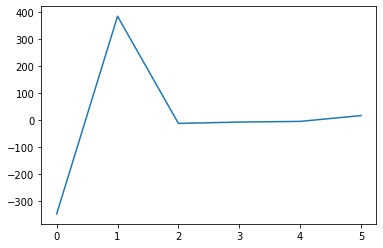

In [ ]:
plt.plot(model.ridge_model.coef_)

###Predictions

In [ ]:
public_energy_to_class_mapping = {1:0,
                                  3:1,
                                  6:0,
                                  10:1,
                                  20:0,
                                  30:1,}

private_energy_to_class_mapping = {1:1,
                                   3:0,
                                   6:1,
                                   10:0,
                                   20:1,
                                   30:0,}

model = joblib. load('model.joblib')

In [ ]:
def make_submission(public_paths, private_paths, save_csv_path='sub.csv', extract_features=True):
    loop_dicts = ({'type': 'public', 'paths': public_paths},
                  {'type': 'private', 'paths': private_paths})

    return_features = {}
    for  d in loop_dicts:
        print(d['type'])
        if extract_features:
            features = extract_test_data(d['paths']).T
        else:
            features = return_features[d['dtype']]
        if d['type'] == 'public':
            energy_to_class_mapping = public_energy_to_class_mapping
            return_features['public'] = features
        else:
            energy_to_class_mapping = private_energy_to_class_mapping
            return_features['private'] = features
        energys, classes = model.predict(features, energy_to_class_mapping=energy_to_class_mapping)
        
        dict_pred['id'] += [n.stem for n in d['paths']]
        dict_pred['classification_predictions'] += classes.tolist()
        dict_pred['regression_predictions'] += energys.tolist()

    data_frame = pd.DataFrame(dict_pred, columns=["id", "classification_predictions", "regression_predictions"])
    return data_frame, dict_pred, return_features

In [ ]:
public_paths = list(public_dir.glob('*.png'))
private_paths = list(private_dir.glob('*.png'))

dict_pred = defaultdict(list)
dict_pred['id'] = []
dict_pred['classification_predictions'] = []
dict_pred['regression_predictions'] = []

data_frame, dict_pred, return_features = make_submission(public_paths, private_paths)

public


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



(array([ 1.,  3.,  6., 10., 20., 30.]), array([253, 290, 209, 253, 251, 246]))
(array([None], dtype=object), array([1]))
private


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



(array([ 1.,  3.,  6., 10., 20., 30.]), array([3641, 1401, 2485, 2472, 2846, 2213]))
(array([None], dtype=object), array([1]))


In [ ]:
data_frame['classification_predictions'] = data_frame['classification_predictions'].map(lambda x: x[0])
data_frame['regression_predictions'] = data_frame['regression_predictions'].map(lambda x: x[0])

In [ ]:
print(np.unique(data_frame['regression_predictions'][:1502], return_counts=True))
print(np.unique(data_frame['regression_predictions'][1502:], return_counts=True))

(array([ 1.,  3.,  6., 10., 20., 30.]), array([253, 290, 209, 253, 251, 246]))
(array([ 1.,  3.,  6., 10., 20., 30.]), array([3641, 1401, 2485, 2472, 2846, 2213]))


In [ ]:
data_frame.to_csv('submission_linear_features.csv', index=False, header=True)

In [ ]:
data_frame

id  ...  regression_predictions
0      03168f1b386cf6b93e39960c0ae79bd872da8cdd  ...                     1.0
1      c7ad8c8e667d587a6eb9d311797658eb0d6c8518  ...                     3.0
2      e13d672f0fb51997339c219355e266c7314f440d  ...                     6.0
3      d52823aaa4f2043e843343768a7cfcbe616fabf3  ...                     3.0
4      a42ec6456b466128f6e32dba1edcef80033263a6  ...                    30.0
...                                         ...  ...                     ...
16555  015be020667adf0b67cf0034dbb0ff0ff69b1658  ...                     6.0
16556  4bcf8eee35625640fe691163bb738de4235100da  ...                    30.0
16557  13b6e816941d11ba6e43268a09f1e11c44503480  ...                     6.0
16558  66dd17d11630a890a7ffdcb68b17681fc92d48ba  ...                    20.0
16559  ffa7aaab0e1b63ee53edae7b115dbd1e922cf2cc  ...                     6.0

[16560 rows x 3 columns]